In [1]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0)
ERROR: No matching distribution found for tensorflow==1.14.0


#Importing Libraries

In [4]:
import os
from io import StringIO
import tarfile
import tempfile
import urllib
import cv2
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
print(tf.__version__)

2.12.0


#Preprocessing

In [5]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')
  
  

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()



LABEL_NAMES = np.asarray([
  'wall','background','building, edifice','sky','floor, flooring','tree','ceiling','road, route','bed ','windowpane, window ','grass','cabinet','sidewalk, pavement','person, individual, someone, somebody, mortal, soul','earth, ground','door, double door','table','mountain, mount','plant, flora, plant life','curtain, drape, drapery, mantle, pall','chair','car, auto, automobile, machine, motorcar','water','painting, picture','sofa, couch, lounge','shelf','house','sea','mirror','rug, carpet, carpeting','field','armchair','seat','fence, fencing','desk','rock, stone','wardrobe, closet, press','lamp','bathtub, bathing tub, bath, tub','railing, rail','cushion','base, pedestal, stand','box','column, pillar','signboard, sign','chest of drawers, chest, bureau, dresser','counter','sand','sink','skyscraper','fireplace, hearth, open fireplace','refrigerator, icebox','grandstand, covered stand','path','stairs, steps','runway','case, display case, showcase, vitrine','pool table, billiard table, snooker table','pillow','screen door, screen','stairway, staircase','river','bridge, span','bookcase','blind, screen','coffee table, cocktail table','toilet, can, commode, crapper, pot, potty, stool, throne','flower','book','hill','bench','countertop','stove, kitchen stove, range, kitchen range, cooking stove','palm, palm tree','kitchen island','computer, computing machine, computing device, data processor, electronic computer, information processing system','swivel chair','boat','bar','arcade machine','hovel, hut, hutch, shack, shanty','bus, autobus, coach, charabanc, double-decker, jitney, motorbus, motorcoach, omnibus, passenger vehicle','towel','light, light source','truck, motortruck','tower','chandelier, pendant, pendent','awning, sunshade, sunblind','streetlight, street lamp','booth, cubicle, stall, kiosk','television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box','airplane, aeroplane, plane','dirt track','apparel, wearing apparel, dress, clothes','pole','land, ground, soil','bannister, banister, balustrade, balusters, handrail','escalator, moving staircase, moving stairway','ottoman, pouf, pouffe, puff, hassock','bottle','buffet, counter, sideboard','poster, posting, placard, notice, bill, card','stage','van','ship','fountain','conveyer belt, conveyor belt, conveyer, conveyor, transporter','canopy','washer, automatic washer, washing machine','plaything, toy','swimming pool, swimming bath, natatorium','stool','barrel, cask','basket, handbasket','waterfall, falls','tent, collapsible shelter','bag','minibike, motorbike','cradle','oven','ball','food, solid food','step, stair','tank, storage tank','trade name, brand name, brand, marque','microwave, microwave oven','pot, flowerpot','animal, animate being, beast, brute, creature, fauna','bicycle, bike, wheel, cycle ','lake','dishwasher, dish washer, dishwashing machine','screen, silver screen, projection screen','blanket, cover','sculpture','hood, exhaust hood','sconce','vase','traffic light, traffic signal, stoplight','tray','ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin','fan','pier, wharf, wharfage, dock','crt screen','plate','monitor, monitoring device','bulletin board, notice board','shower','radiator','glass, drinking glass','clock','flag'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


#Loading model

In [1]:
MODEL_NAME = 'deeplabv3_xception_ade20k_train'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'deeplabv3_xception_ade20k_train':'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

NameError: ignored

#Segmentation

In [5]:
from google.colab import files
from os import path

file_name = 'img.jpg'
uploaded = files.upload()
  
for name, data in uploaded.items():
  with open(file_name, 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

orignal_im = Image.open(name)

print('running deeplab on image %s...' % file_name)
resized_im, seg_map = MODEL.run(orignal_im)
vis_segmentation(resized_im, seg_map)

KeyboardInterrupt: ignored

In [ ]:
w,h=resized_im.size
print(w,h)

In [ ]:
print(seg_map)

In [ ]:
for i in range(h):
  for j in range(w):
    if seg_map[i][j]==1:
      seg_map[i][j]=1
    else:
      seg_map[i][j]=0

In [ ]:
mask_j=np.repeat(seg_map[...,None],3,axis=2)


In [ ]:
mask_j[np.where((mask_j==[1,1,1]).any(axis=2))] = [0,0,255]


In [ ]:
i=mask_j*resized_im


#Results

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
final=resized_im
plt.imshow(final+i)
#plt.imshow(mask_j+resized_im)
plt.axis('off')
plt.title('coloured image')

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
#plt.imshow(e)
plt.imshow(mask_j+resized_im)
plt.axis('off')
plt.title('coloured image')

In [ ]:
for i in range(h):
  for j in range(w):
    if seg_map[i][j]==1:
      seg_map[i][j]=0
    else:
      seg_map[i][j]=1

In [ ]:
#plt.imshow(seg_map)

In [ ]:
mask_s=np.repeat(seg_map[...,None],3,axis=2)
#plt.imshow(mask_s*resized_im)

In [ ]:
#plt.imshow(mask_j+(mask_s*resized_im))

In [ ]:
l=cv2.bitwise_or(mask_j,mask_s)
#plt.imshow(l)

In [ ]:
e=l+resized_im
plt.imshow(e)

In [ ]:
e=l+resized_im
plt.imshow(e)

In [ ]:
plt.imshow(mask_j+resized_im)

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
#plt.imshow(e)
plt.imshow(mask_j+resized_im)
plt.axis('off')
plt.title('coloured image')

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(e)
plt.axis('off')
plt.title('coloured image')

#Texture

In [ ]:
import cv2
texture=cv2.imread("brick_texture.jpg")
resized_texture=cv2.resize(texture,(w,h))
#plt.imshow(resized_texture)
I=cv2.cvtColor(resized_texture,cv2.COLOR_BGR2RGB)
plt.imshow(I)
print("shape :",I.shape)
print(I)

In [ ]:
import cv2
texture=cv2.imread("small_tex.jpg")
#resized_texture=cv2.resize(texture,(w,h))
#plt.imshow(resized_texture)
I=cv2.cvtColor(texture,cv2.COLOR_BGR2RGB)
plt.imshow(I)
print("shape :",I.shape)
print(I)

In [ ]:
for i in range(h):
  for j in range(w):
    if seg_map[i][j]==1:
      seg_map[i][j]=1
    else:
      seg_map[i][j]=0
#mask=np.repeat(seg_map[...,None],3,axis=2)


In [ ]:
mask=np.repeat(seg_map[...,None],3,axis=2)
t=mask*I
plt.imshow(t)

In [ ]:
i=mask*resized_im
plt.imshow(i)

#Results

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
final=resized_im-i
plt.imshow(final+t)
#plt.imshow(resized_im+t)
plt.axis('off')
plt.title('textured image')

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
final=resized_im-i
plt.imshow(final+t)
plt.axis('off')
plt.title('textured image')

In [ ]:
#middle=cv2.bitwise_or(u,t)
plt.imshow(t+resized_im)

In [ ]:
middle=cv2.bitwise_or(t,m)
plt.imshow(middle+resized_im)

In [ ]:
middle=cv2.bitwise_or(t,m)
plt.imshow(middle+resized_im)

In [ ]:
middle=cv2.bitwise_or(t,m)
plt.imshow(middle+resized_im)

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(middle+resized_im)
plt.axis('off')
plt.title('textured image')

In [ ]:
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(resized_im)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(middle+resized_im)
plt.axis('off')
plt.title('textured image')

# Layout -2

In [ ]:
!git clone https://github.com/GitBoSun/roomnet.git

Cloning into 'roomnet'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.


In [ ]:
!python /content/roomnet/roomnet/main.py --train 0 --net vanilla --out_path /content

2020-12-08 17:31:43.398205: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/content/roomnet/roomnet/main.py", line 11, in <module>
    from get_res import get_im
  File "/content/roomnet/roomnet/get_res.py", line 5, in <module>
    out=np.load('sample.npz')
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 428, in load
    fid = open(os_fspath(file), "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'sample.npz'


#Try Texture

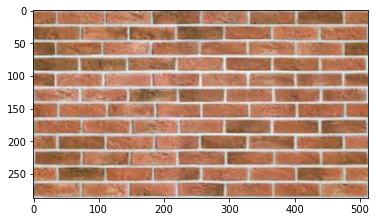

In [ ]:
import cv2
texture=cv2.imread("brick_texture.jpg")
resized_texture=cv2.resize(texture,(w,h))
#plt.imshow(resized_texture)
I=cv2.cvtColor(resized_texture,cv2.COLOR_BGR2RGB)
plt.imshow(I)

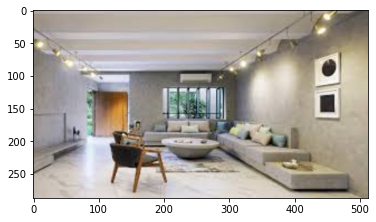

In [ ]:
import cv2
input_im=cv2.imread("room_3.jpg")
resized_image=cv2.resize(input_im,(w,h))
#plt.imshow(resized_texture)
input_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
plt.imshow(input_image)

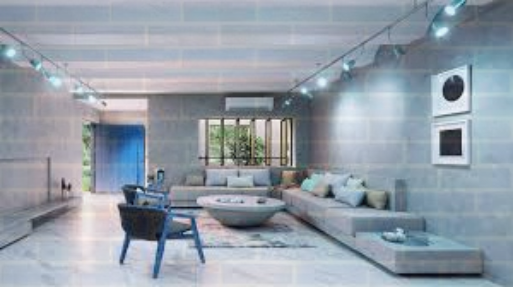

In [ ]:
final_img = cv2.addWeighted(I, 0.3,input_image,0.7,0) 
cv2_imshow(final_img)

In [ ]:
cv2_imshow(I*input_image)

In [ ]:
for i in range(h):
  for j in range(w):
    if seg_map[i][j]==1:
      seg_map[i][j]=1
    else:
      seg_map[i][j]=0

In [ ]:
mask=np.repeat(seg_map[...,None],3,axis=2)


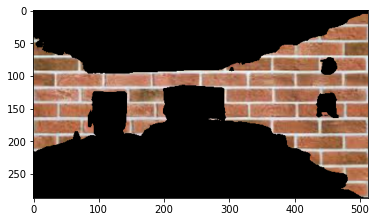

In [ ]:
plt.imshow(mask*I)

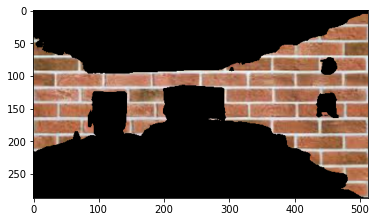

In [ ]:
plt.imshow(I+mask)